In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# BibTex Citation

# @article{kirillov2023segany,
#   title={Segment Anything},
#   author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead, Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and Girshick, Ross},
#   journal={arXiv:2304.02643},
#   year={2023}
# }

# @article{cai2022efficientvit,
#   title={Efficientvit: Enhanced linear attention for high-resolution low-computation visual recognition},
#   author={Cai, Han and Gan, Chuang and Han, Song},
#   journal={arXiv preprint arXiv:2205.14756},
#   year={2022}
# }

# Setup

Before starting, make sure that you have a conda instance installed on your computer, as well as git.

Your first step is to create the virtual environment. In this case, I am running this on RTX 3090s and 4090s, which support CUDA 12.1. If you have a decently modern GPU, it should support CUDA 12.1.

```
conda create --name cuda121 python=3.11 -y
conda activate cuda121
```

From there, you install pytorch with cuda support through conda.

```
conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
```

Then, install the remaining packages from the requirements.txt file located in the repo. In your repo folder or IDE, right click on the file and click "Copy as Path." Replace the requirements.txt with the path you copied.

```
pip install -r requirements.txt
```

Lastly, select your conda installation as your kernel and run the script below. It should print your CUDA installation details, and you should see a "True" at the bottom if CUDA is enabled.


In [1]:
!conda activate cuda121

!nvcc --version
import torch
print(torch.__version__)
print(torch.cuda.is_available())

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0
2.2.2
True


Next, we need to install the EfficientViT library into this folder and add it to the virtual environment. You should only have to run this the first time you run this script, after that it should be installed.

In [3]:
# Install EfficientViT
!git clone https://github.com/mit-han-lab/efficientvit
%cd efficientvit
%pip install -e .

a:\Programs\SAM-for-Binary-Mask-File-Generation\efficientvit


Cloning into 'efficientvit'...
c:\Users\andre\anaconda3\envs\cuda121\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Obtaining file:///A:/Programs/SAM-for-Binary-Mask-File-Generation/efficientvit
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Using cached torchpack-0.3.1-py3-none-any.whl
  Cloning https://github.com/alibaba/TinyNeuralNetwork.git to c:\users\andre\appdata\local\temp\pip-install-8en2gfqo\tinyneuralnetwork_6f69054da2cc4263ab674f39badf8650
  Resolved https://github.com/alibaba/TinyNeuralNetwork.git to commit d8b2a349bb87b6fee06e35180e06c5bf4a61a514
  Installing build dependencies: started
  Insta

  Running command git clone --filter=blob:none --quiet https://github.com/alibaba/TinyNeuralNetwork.git 'C:\Users\andre\AppData\Local\Temp\pip-install-8en2gfqo\tinyneuralnetwork_6f69054da2cc4263ab674f39badf8650'
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\andre\AppData\Local\Temp\pip-install-8en2gfqo\segment-anything_c7c3949494f74cc9a96a242521d7d034'


You can check if the installation is verified here:

In [1]:
# Verify the installation
try:
    import efficientvit
    print("EfficientViT successfully installed!")
except ImportError:
    print("EfficientViT installation failed. Please check the error messages.")


EfficientViT successfully installed!


Before we continue, to keep the folder structure a bit more organized, run this block of code. It will create a "models", "input" and "output" folder. These are already added inside the gitignore file, so don't worry about them clogging up the git repo.

In [2]:
repo_dir = r"A:\Programs\SAM-for-Binary-Mask-File-Generation" # Change this to your directory

In [3]:
import os, sys

# Change the current working directory to repo_dir
os.chdir(repo_dir)

# Get the updated current working directory
cwd = os.getcwd()
print(cwd)

# Define the folder names
folder_names = ['models', 'input', 'output']

# Loop through the folder names and create the folders
for folder_name in folder_names:
    folder_path = os.path.join(cwd, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created folder: {folder_path}")

A:\Programs\SAM-for-Binary-Mask-File-Generation
Created folder: A:\Programs\SAM-for-Binary-Mask-File-Generation\models
Created folder: A:\Programs\SAM-for-Binary-Mask-File-Generation\input
Created folder: A:\Programs\SAM-for-Binary-Mask-File-Generation\output


Now, we just import some dependencies and define the mask functions.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Sequential Renaming of Folder

Run following two blocks if you haven't before, renames each image in folder to a number sequentially

In [6]:
# Path to the directory containing the image sequence
directory_path = os.path.join(repo_dir, 'input')


In [8]:
import os
os.getcwd()
for i, filename in enumerate(os.listdir(dir)):
    if filename != str(i) + '.tif':
        os.rename(dir + '//' + filename,dir + '//' + str(i) + '.tif')

TypeError: listdir: path should be string, bytes, os.PathLike or None, not builtin_function_or_method

Below are functions that are used to rename files within the folder sequentially, using a 4 digit numbering system (i.e., 0001, 0002, 0003, ...)

These functions may not be applicable to your file naming conventions, and need to be modified to your specific needs.

In [9]:
import os

# Word to remove from the filenames
word_to_remove = "Camera_15_46_55_"

# List all files in the directory
image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

# Iterate through the image files and rename them
for image_file in image_files:
    # Split the filename and extension
    base_filename, file_extension = os.path.splitext(image_file)
    
    # Remove the word from the filename
    new_base_filename = base_filename.replace(word_to_remove, "")
    
    # Construct the new filename
    new_filename = new_base_filename + file_extension
    
    # Build the full path to the old and new file
    old_file_path = os.path.join(directory_path, image_file)
    new_file_path = os.path.join(directory_path, new_filename)
    
    # Rename the file
    os.rename(old_file_path, new_file_path)

In [10]:
# Sort the image files by their numerical order
image_files.sort(key=lambda x: int(os.path.splitext(x)[0]))

# Initialize a counter
counter = 0

# Iterate through the image files and rename them to a sequential numbered list
for image_file in image_files:
    # Get the file extension (e.g., .jpg, .png)
    file_extension = os.path.splitext(image_file)[-1]
    
    # Construct the new filename with a numbered list
    new_filename = f"{counter:04d}{file_extension}"  # Use 4 digits for the number
    
    # Build the full path to the old and new file
    old_file_path = os.path.join(directory_path, image_file)
    new_file_path = os.path.join(directory_path, new_filename)
    
    # Rename the file
    os.rename(old_file_path, new_file_path)
    
    # Increment the counter
    counter += 1

Turn renamed and numbered image sequence folder into a list

In [14]:
# Sort folder into an ordered list
import glob
import re
import os

images=[]
count = 0
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s)]

for image in sorted(glob.glob(directory_path + '\*.tiff'),key = natsort):
    img = cv2.imread(image)
    images.append(img)

## Set SAM Checkpoint

First, check your device. A list of all the GPUs that support TensorRT can be found [here](https://docs.nvidia.com/deeplearning/tensorrt/support-matrix/index.html). If you have a GPU that supports TensorRT and fp16 performance, then proceed using the "GPU-accelerated" steps. If not, follow the legacy segment-anything steps in the other branch.

### GPU-Accelerated

We already installed efficientViT in the steps above, so now proceed to this link [here](https://github.com/mit-han-lab/efficientvit/blob/master/applications/sam.md). In the page that just popped up, there are multiple models with different resolutions and benchmark performance. For most usecases, I recommend using the "EfficientViT-SAM-L2" model. If you click the link on the right side of the page, it will download the .pt file. Once that's downloaded, place it inside the "models" folder inside this repository.

In [15]:
models_folder = os.path.join(repo_dir, "models")
sys.path.append(models_folder)

# segment anything
from efficientvit.sam_model_zoo import create_sam_model

efficientvit_sam = create_sam_model(
  name="l2", weight_url=os.path.join(models_folder, "l2.pt")
)
efficientvit_sam = efficientvit_sam.cuda().eval()

from efficientvit.models.efficientvit.sam import EfficientViTSamPredictor

efficientvit_sam_predictor = EfficientViTSamPredictor(efficientvit_sam)

from efficientvit.models.efficientvit.sam import EfficientViTSamAutomaticMaskGenerator

efficientvit_mask_generator = EfficientViTSamAutomaticMaskGenerator(efficientvit_sam)


sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = efficientvit_sam

predictor = efficientvit_sam_predictor

Display of first image in folder. Note the coordinate system for future reference.

(-0.5, 399.5, 249.5, -0.5)

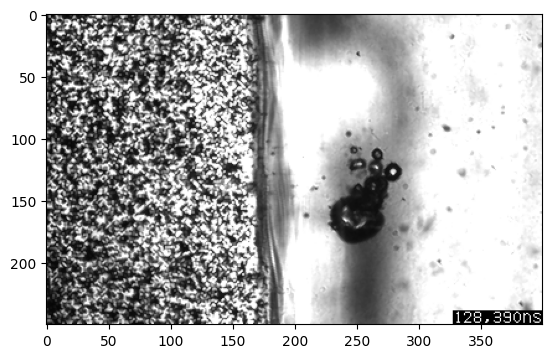

In [16]:
plt.imshow(images[0])
plt.axis('on')

## Segmentation

In the block below, choose a point on the image at which you want segmented.

For example: 

    input_point = np.array([[50,100]])
    input_label = np.array([1])

This would set one point on the image at (50,100) and highlight the predicted segment.

Also:

    input_point = np.array([[50,100],[100,200]])
    input_label = np.array([1,1])

This would choose two points and run the same prediction model.



For each image, the model will display three different segment predictions. You may choose the best one and save only that number into your output folder. Or, if desired, two or all images can be saved.


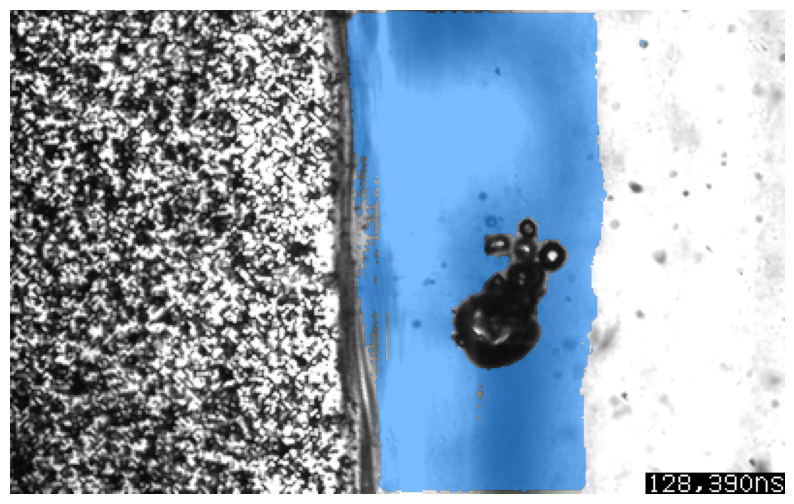

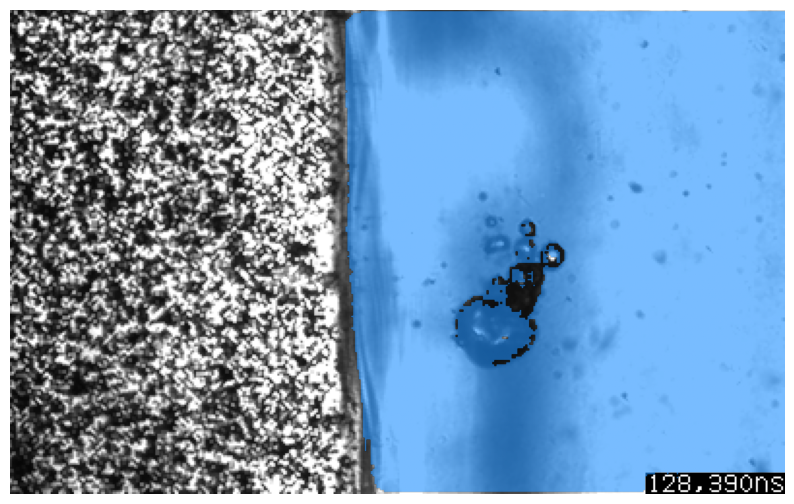

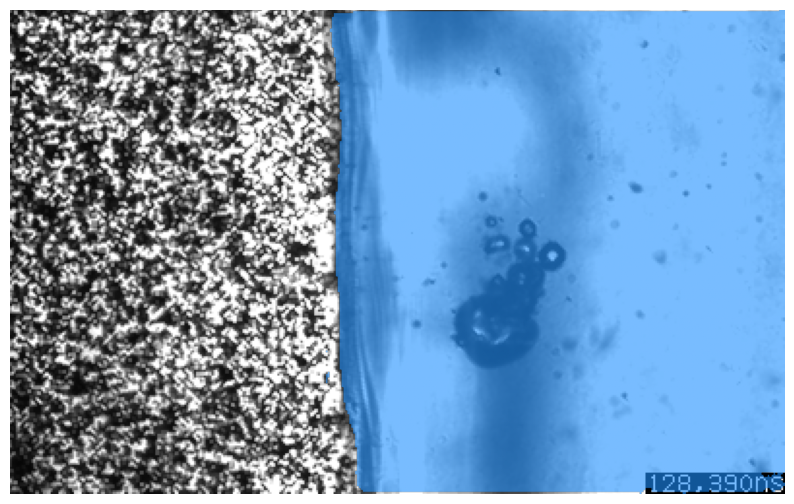

In [17]:
# Change this number to choose different images within your input folder
im_num = 0

predictor.set_image(images[im_num])
    
# Set coordinate and number of points for segmentation
input_point = np.array([[200,200]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
point_coords=input_point,
point_labels=input_label,
multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(images[im_num])
    show_mask(mask, plt.gca())
    plt.axis('off')

Note which number provides the best segmentation results, it can be chosen in the next block. First image is 0, second image is 1, third image is 2.

Feel free to run multiple images to confirm your choice.

This next block iterates over the entire image sequence. Make sure to choose the correct number to save only the desired mask files.

This will run for a long time (about 30-45 seconds per image). 

In [18]:
# Declare which image you would like to move forward with (0,1, or 2)

best_img = 0

In [19]:
# Output folder Path
# Folder should already exist

output = ''

Set the input_point and input_label that was used above to yield desired results. 

These prompts will be used for every image in the image sequence. Make sure that the point(s) being used as your segmentation prompt will provide correct segmentation results throughout the entire image sequence, especially in for applications with large deformations. If necessary, modify the ranges of the for loop and run the code sectionally with different input prompts.

In [20]:
input_point = np.array([[200,200]])
input_label = np.array([1])

Modify the block below to the size and dpi of your images 

In [21]:
w = 400
l = 250
dpi = 96

Time to run model for image 1: 0.07000184059143066 seconds


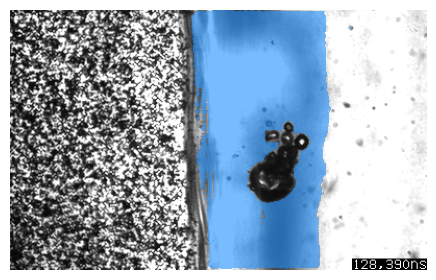

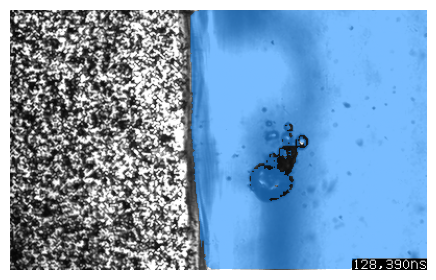

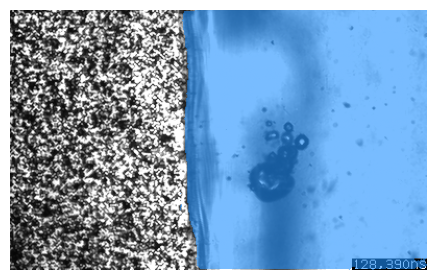

In [23]:
import time
count = 0
for image in images[0:]:
    start_time = time.time()  # Start the timer
    
    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    for i, (mask, score) in enumerate(zip(masks, scores)):
        fig = plt.figure(figsize=(w/dpi, l/dpi))
        ax = fig.add_axes([0, 0, 1, 1])
        plt.imshow(image)
        show_mask(mask, plt.gca())
        ax.axis('off')
        ax.set(xlim=[-0.5, w - 0.5], ylim=[l - 0.5, -0.5], aspect=1)
        if i == best_img:
            plt.savefig(output + f'\\{count:04d}.tif', dpi=dpi, transparent=True)
    
    count += 1
    
    end_time = time.time()  # Stop the timer
    elapsed_time = end_time - start_time
    print(f"Time to run model for image {count}: {elapsed_time} seconds")


After the for loop is done running, you may notice a few bad frames. You can always go back and check the three different possible outputs for each individual image and change the image number (0,1,2) to reflect the best image. The range of the for loop can be changed to run select images again.